# Market Research Services for the Airline Industry

As a market research agency, we specialize in serving clients within the airline industry. Our services encompass a range of offerings, including the detailed analysis of user reviews. These reviews are sourced from a dedicated webpage, [www.airlinequality.com](www.airlinequality.com), which hosts user feedback for over 100 airlines globally.

## Our Scraping Objectives

We focus on two main types of data:

### Quantitative Data Analysis
- **Objective**: To collate and analyze quantitative metrics on an airline's quality level.
- **Data Types**:
  - Airline recommendation rates.
  - Ratings for cabin staff, food and beverage, ground service, inflight entertainment, seat comfort, value for money, and WIFI/connectivity.
- **Data Structuring**: Organized by country of origin, flight date, route, and seat type.
- **Analysis Goals**:
  - Assessing recommendation rates.
  - Calculating average ratings per category.
  - Determining the distribution of travelers across different seat types.

### Qualitative Data Analysis
- **Objective**: To gather and interpret qualitative aspects of an airline's service quality.
- **Data Types**: Review texts from customers.
- **Analysis Goals**: Creating word clouds to highlight frequently mentioned elements in the reviews.

## Overall Objective

Our primary goal is to provide airlines with a thorough understanding of customer perceptions and potential areas for improvement. This involves not only analyzing their performance but also benchmarking them against their competitors to offer a comprehensive market perspective.


In [78]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [82]:
SA_URL = "https://www.airlinequality.com/airline-reviews/saudi-arabian-airlines/page/"
BA_URL = "https://www.airlinequality.com/airline-reviews/british-airways/page/"

In [2]:
def convert_date(date_string):
    try:
        # Removing ordinal suffixes
        clean_date = date_string.replace('st', '').replace('nd', '').replace('rd', '').replace('th', '')
        # Attempt to parse the date
        date_object = datetime.strptime(clean_date, '%d %B %Y')
        return date_object.strftime('%d-%m-%Y')
        
    except ValueError:
        # Return NaN if parsing fails
        return np.nan

In [6]:
def airlines_List_Finder():
    url = "https://www.airlinequality.com/review-pages/a-z-airline-reviews/"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    airline_links = {}
    
    # Targeting the specific sections that contain airline reviews
    # Assuming that the links we are interested in are not in the 'Latest Airline Reviews' section
    review_sections = soup.find_all('section', id=lambda x: x and x != 'Latest Airline Reviews')

    for section in review_sections:
        for link in section.find_all('a', href=True):
            href = link['href']
            if '/airline-reviews/' in href:
                airline_name = link.get_text().strip()
                airline_links[airline_name] = href

    return airline_links


In [7]:
# Example usage
airline_links = airlines_List_Finder()
for name, link in airline_links.items():
    print(f"{name}: {link}")

In [52]:
def scrape_page(base_url, pages=10):
    all_reviews = []  # Initialize list to store all reviews

    for page in range(1, pages + 1):
        response = requests.get(base_url + str(page))  # Fetch page content
        soup = BeautifulSoup(response.text, 'html.parser')  # Parse HTML content with BeautifulSoup

        for container in soup.find_all('div', class_='body'):  # Iterate over each review container
            # Extract and create dictionary of table data (ratings, etc.) using dictionary comprehension
            review = {row.find('td', class_='review-rating-header').get_text(strip=True):
                      row.find('td', class_='review-value').get_text(strip=True)
                      if row.find('td', class_='review-value') else
                      int(len(row.find_all('span', class_='star fill')))
                      for row in container.find_all('tr')}

            # Extract and add additional review data (name, country, date, comment)
            review.update({
                'name': container.find('span', itemprop="name").get_text(strip=True),
                'country': re.search(r'\((.*?)\)', container.find('h3').get_text()).group(1),
                'date': convert_date(container.find('time', itemprop="datePublished").get_text(strip=True)),
                'comment': container.find('h2').get_text(strip=True)
            })

            all_reviews.append(review)  # Add the extracted review data to the list

    return all_reviews  # Return the list of all reviews

In [80]:
SA_result = scrape_page(SA_URL)

In [84]:
BA_result = scrape_page(BA_URL)

In [85]:
df_SA = pd.DataFrame(result)
df_SA.head()

,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Recommended,name,country,date,comment,Aircraft
0,Couple Leisure,Economy Class,Jeddah to Lahore,November 2023,3.0,2.0,1.0,1.0,1.0,1.0,2,no,Muhammad Irfan Masood,Pakistan,21-11-2023,"“staff was rude, unprofessional and cheap”",NaN
1,Solo Leisure,Economy Class,Addis Ababa to Jeddah,November 2023,4.0,4.0,5.0,NaN,3.0,NaN,4,yes,L Wilson,United States,21-11-2023,“Really good flight”,NaN
2,Family Leisure,Economy Class,Riyadh to London,September 2023,5.0,5.0,5.0,5.0,5.0,5.0,5,yes,Dhay Alharbi,Saudi Arabia,19-11-2023,"""It was a great experience""",Boeing 777
3,Solo Leisure,Business Class,Kuwait to Riyadh via Jeddah & Bangkok,October 2023,5.0,3.0,2.0,3.0,3.0,NaN,5,yes,Anders Pedersen,Denmark,31-10-2023,"""largest SkyTeam lounge worldwide""",A320 / Boeing 787-10
4,Family Leisure,Economy Class,Cairo to Jeddah,October 2023,4.0,4.0,1.0,4.0,1.0,NaN,2,no,Rashawn Hughes,United States,29-10-2023,"""tried changing our meals to vegan at check in""",NaN


In [86]:
df_BA = pd.DataFrame(result)
df_BA.head()

,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Recommended,name,country,date,comment,Aircraft
0,Couple Leisure,Economy Class,Jeddah to Lahore,November 2023,3.0,2.0,1.0,1.0,1.0,1.0,2,no,Muhammad Irfan Masood,Pakistan,21-11-2023,"“staff was rude, unprofessional and cheap”",NaN
1,Solo Leisure,Economy Class,Addis Ababa to Jeddah,November 2023,4.0,4.0,5.0,NaN,3.0,NaN,4,yes,L Wilson,United States,21-11-2023,“Really good flight”,NaN
2,Family Leisure,Economy Class,Riyadh to London,September 2023,5.0,5.0,5.0,5.0,5.0,5.0,5,yes,Dhay Alharbi,Saudi Arabia,19-11-2023,"""It was a great experience""",Boeing 777
3,Solo Leisure,Business Class,Kuwait to Riyadh via Jeddah & Bangkok,October 2023,5.0,3.0,2.0,3.0,3.0,NaN,5,yes,Anders Pedersen,Denmark,31-10-2023,"""largest SkyTeam lounge worldwide""",A320 / Boeing 787-10
4,Family Leisure,Economy Class,Cairo to Jeddah,October 2023,4.0,4.0,1.0,4.0,1.0,NaN,2,no,Rashawn Hughes,United States,29-10-2023,"""tried changing our meals to vegan at check in""",NaN


In [87]:
def transform_and_rename_dataframe(dictionary, column_order, new_column_names):
    #transform dict in df
    df1 = pd.DataFrame(dictionary)
    
    # Reorder the columns
    df2 = df1.reindex(columns=column_order)

    # Check if the number of new column names matches the number of columns in df2
    if len(new_column_names) != len(df2.columns):
        raise ValueError("The number of new column names must match the number of columns in the DataFrame")

    # Rename the columns
    df2.columns = new_column_names

    return df2

In [93]:
df_SA = transform_and_rename_dataframe(SA_result, ['name', 'country', 'date', 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity', 'Value For Money', 'Recommended', 'comment'], ['Name', 'Country', 'Date', 'Traveller Type', 'Seat Type', 'Route', 'Date Flown', 'Seat Comfort /5', 'Cabin Staff Service /5', 'Food & Beverages /5', 'Inflight Entertainment /5', 'Ground Service /5', 'Wifi & Connectivity /5', 'Value For Money /5', 'Recommended', 'Comment'])

In [96]:
df_BA = transform_and_rename_dataframe(BA_result, ['name', 'country', 'date', 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity', 'Value For Money', 'Recommended', 'comment'], ['Name', 'Country', 'Date', 'Traveller Type', 'Seat Type', 'Route', 'Date Flown', 'Seat Comfort /5', 'Cabin Staff Service /5', 'Food & Beverages /5', 'Inflight Entertainment /5', 'Ground Service /5', 'Wifi & Connectivity /5', 'Value For Money /5', 'Recommended', 'Comment'])

In [95]:
df_SA.head()

,Name,Country,Date,Traveller Type,Seat Type,Route,Date Flown,Seat Comfort /5,Cabin Staff Service /5,Food & Beverages /5,Inflight Entertainment /5,Ground Service /5,Wifi & Connectivity /5,Value For Money /5,Recommended,Comment
0,Muhammad Irfan Masood,Pakistan,21-11-2023,Couple Leisure,Economy Class,Jeddah to Lahore,November 2023,3.0,2.0,1.0,1.0,1.0,1.0,2,no,"“staff was rude, unprofessional and cheap”"
1,L Wilson,United States,21-11-2023,Solo Leisure,Economy Class,Addis Ababa to Jeddah,November 2023,4.0,4.0,5.0,NaN,3.0,NaN,4,yes,“Really good flight”
2,Dhay Alharbi,Saudi Arabia,19-11-2023,Family Leisure,Economy Class,Riyadh to London,September 2023,5.0,5.0,5.0,5.0,5.0,5.0,5,yes,"""It was a great experience"""
3,Anders Pedersen,Denmark,31-10-2023,Solo Leisure,Business Class,Kuwait to Riyadh via Jeddah & Bangkok,October 2023,5.0,3.0,2.0,3.0,3.0,NaN,5,yes,"""largest SkyTeam lounge worldwide"""
4,Rashawn Hughes,United States,29-10-2023,Family Leisure,Economy Class,Cairo to Jeddah,October 2023,4.0,4.0,1.0,4.0,1.0,NaN,2,no,"""tried changing our meals to vegan at check in"""


In [97]:
df_BA.head()

,Name,Country,Date,Traveller Type,Seat Type,Route,Date Flown,Seat Comfort /5,Cabin Staff Service /5,Food & Beverages /5,Inflight Entertainment /5,Ground Service /5,Wifi & Connectivity /5,Value For Money /5,Recommended,Comment
0,Bert Vissers,Switzerland,26-11-2023,Family Leisure,Economy Class,Zürich to Tokyo Haneda via London,July 2023,1.0,1.0,1.0,1.0,1.0,1.0,1,no,"""Buckle up, folks; this one's a rollercoaster"""
1,E Smyth,United Kingdom,23-11-2023,Couple Leisure,First Class,London to Miami,November 2023,5.0,5.0,5.0,5.0,4.0,2.0,4,yes,"""cabin crew excellent"""
2,L Keele,Germany,19-11-2023,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,NaN,NaN,1.0,NaN,1,no,"""Service level far worse then Ryanair"""
3,Austin Jones,United States,19-11-2023,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,1.0,2.0,2,no,"""do not upgrade members based on status"""
4,M A Collie,Ireland,16-11-2023,Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,NaN,4.0,NaN,3,yes,"""Flight was smooth and quick"""


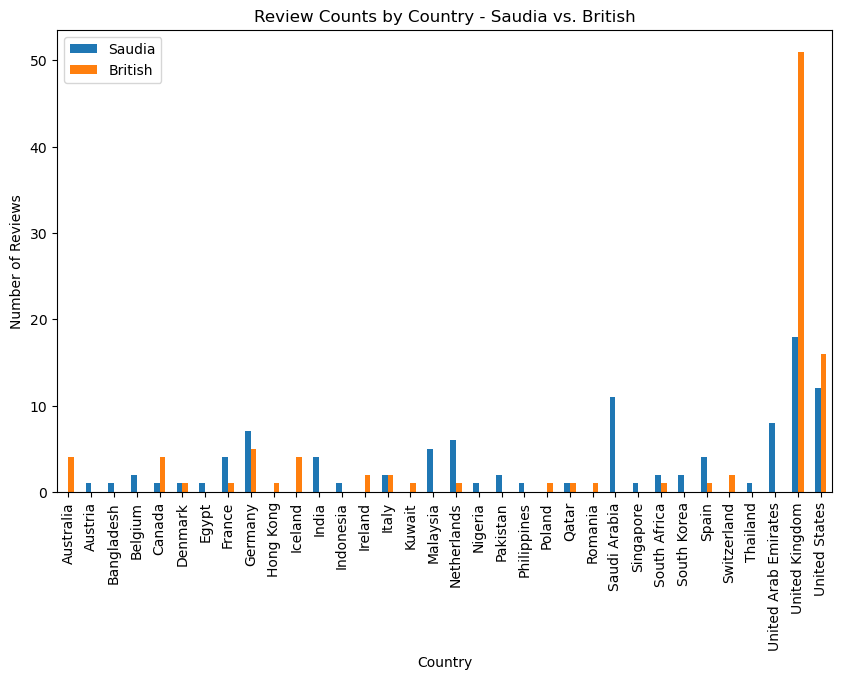

In [99]:
# Calculate country-wise review counts for each DataFrame
country_counts_df1 = df_SA['Country'].value_counts()
country_counts_df2 = df_BA['Country'].value_counts()

# Create a DataFrame for easy plotting
combined_counts = pd.DataFrame({
    'Saudia': country_counts_df1,
    'British': country_counts_df2
}).fillna(0)  # Fill NaN values with 0

# Plotting
combined_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Country')
plt.ylabel('Number of Reviews')
plt.title('Review Counts by Country - Saudia vs. British')
plt.xticks(rotation=90)  # Rotate labels for better readability
plt.legend(['Saudia', 'British'])
plt.show()


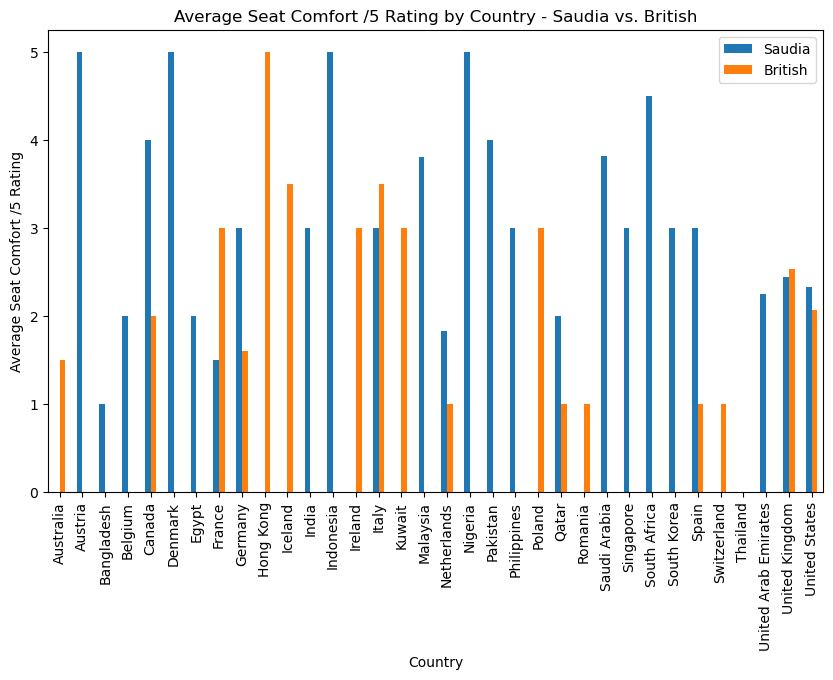

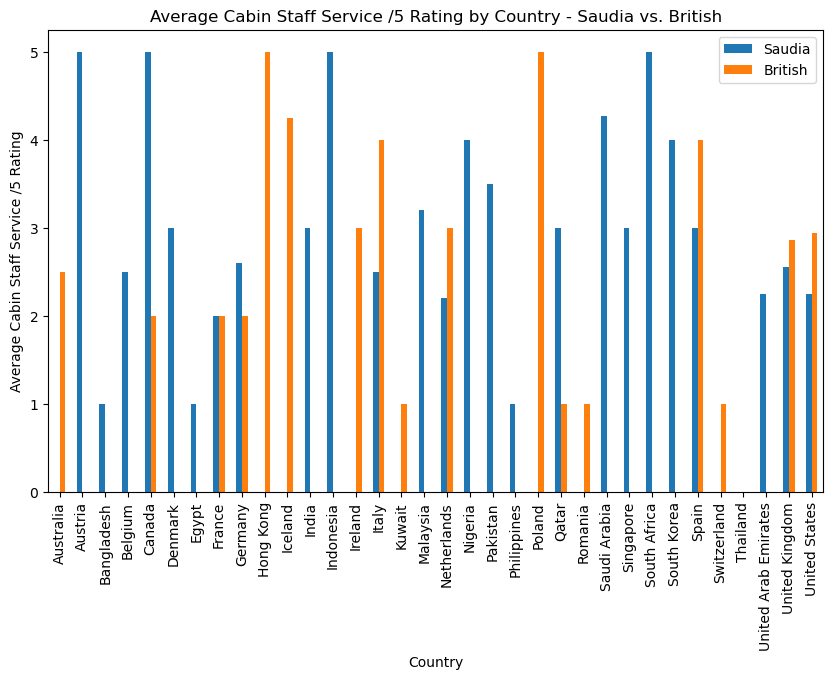

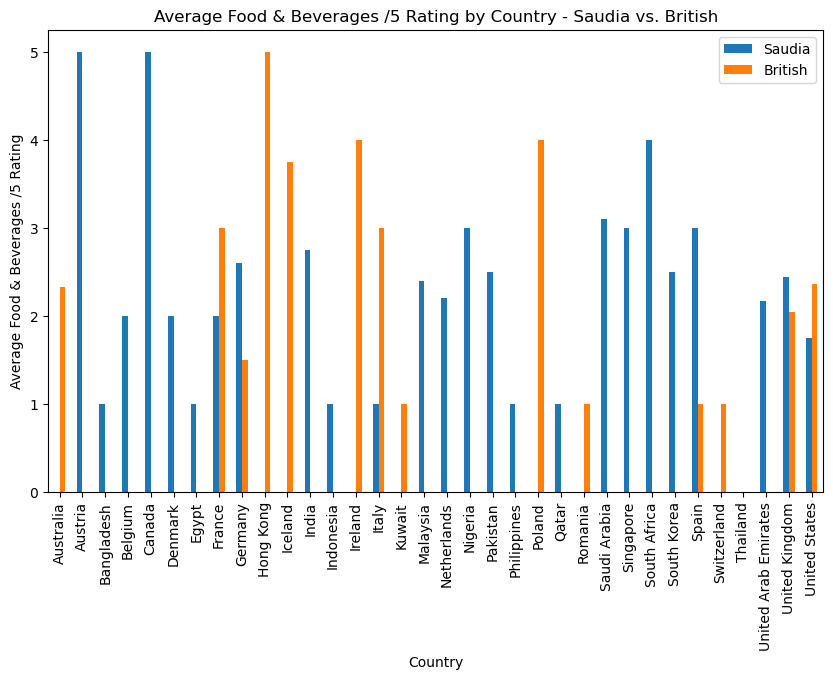

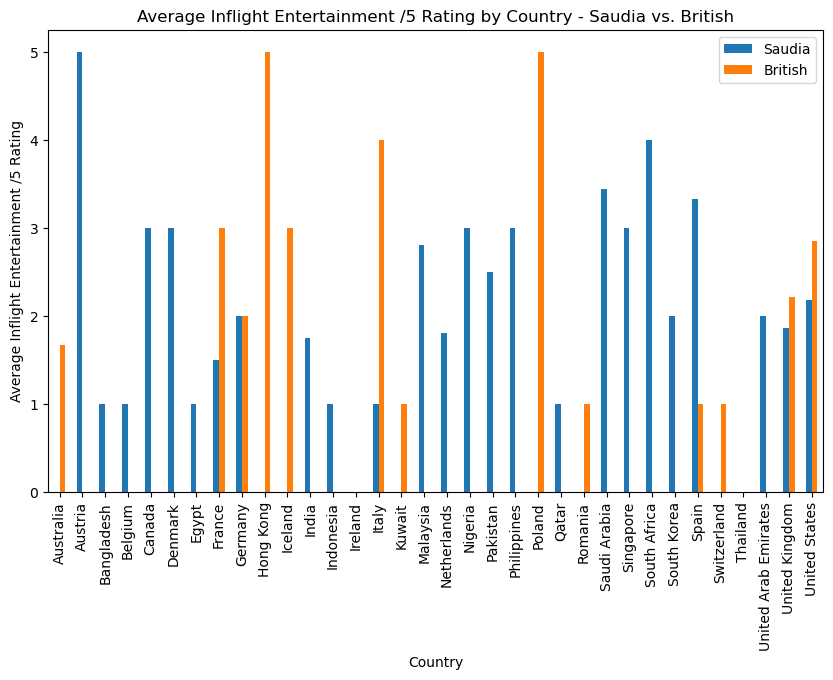

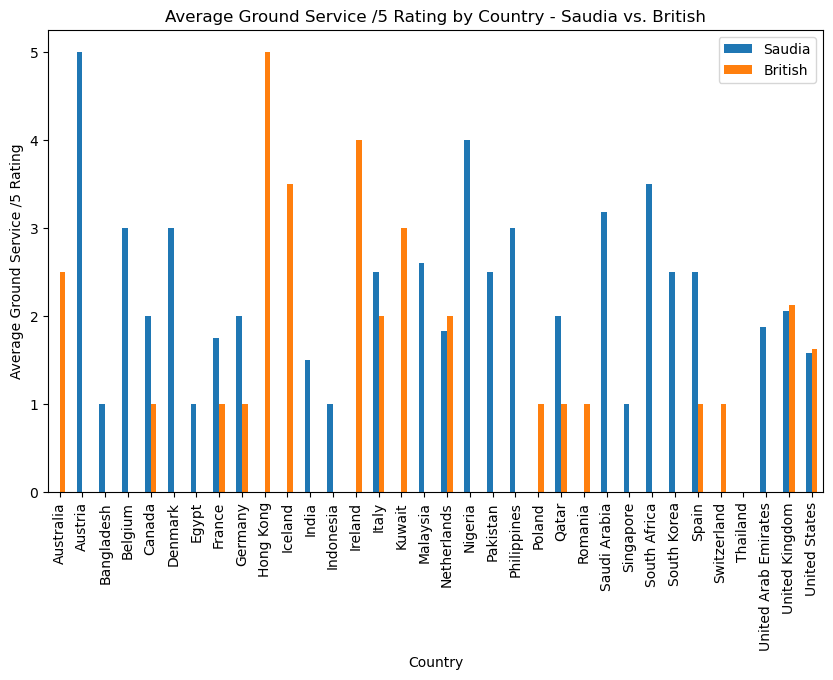

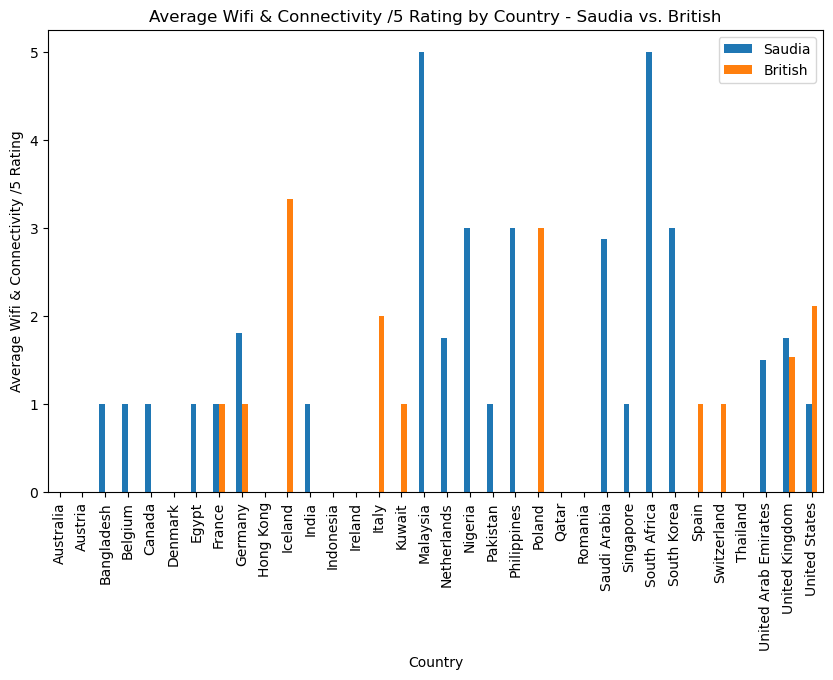

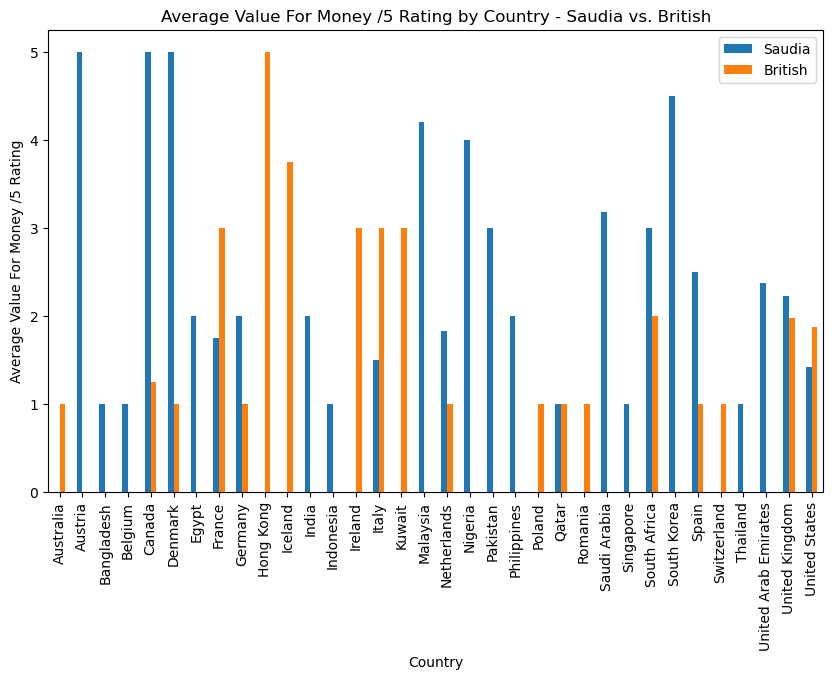

In [100]:
rating_categories = [
    'Seat Comfort /5', 
    'Cabin Staff Service /5', 
    'Food & Beverages /5', 
    'Inflight Entertainment /5', 
    'Ground Service /5', 
    'Wifi & Connectivity /5', 
    'Value For Money /5'
]

# Loop through each rating category
for category in rating_categories:
    # Calculate average rating for each country in both DataFrames
    average_ratings_df1 = df_SA.groupby('Country')[category].mean()
    average_ratings_df2 = df_BA.groupby('Country')[category].mean()

    # Combine the data into a single DataFrame for plotting
    combined_ratings = pd.DataFrame({
        'Saudia': average_ratings_df1,
        'British': average_ratings_df2
    }).fillna(0)  # Fill NaN values with 0

    # Create a bar plot for each category
    ax = combined_ratings.plot(kind='bar', figsize=(10, 6))
    ax.set_xlabel('Country')
    ax.set_ylabel(f'Average {category} Rating')
    ax.set_title(f'Average {category} Rating by Country - Saudia vs. British')
    ax.tick_params(axis='x', rotation=90)
    plt.legend(['Saudia', 'British'])
    plt.show()


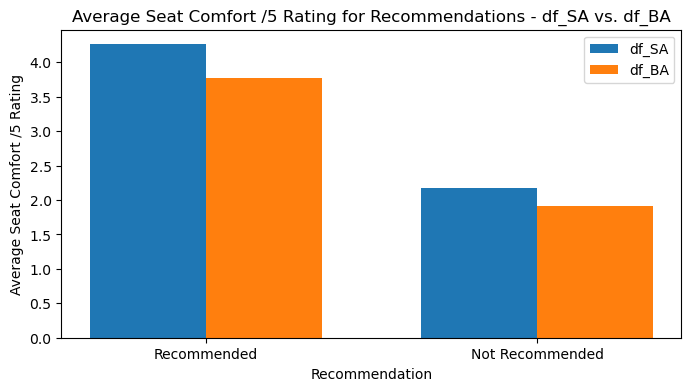

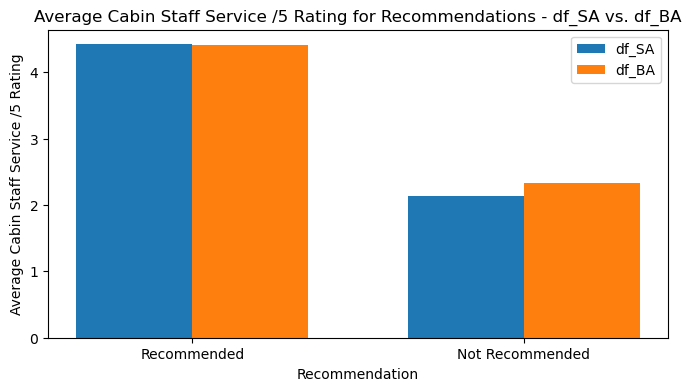

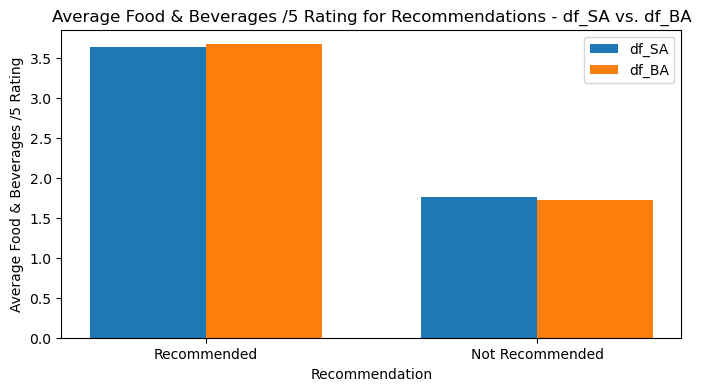

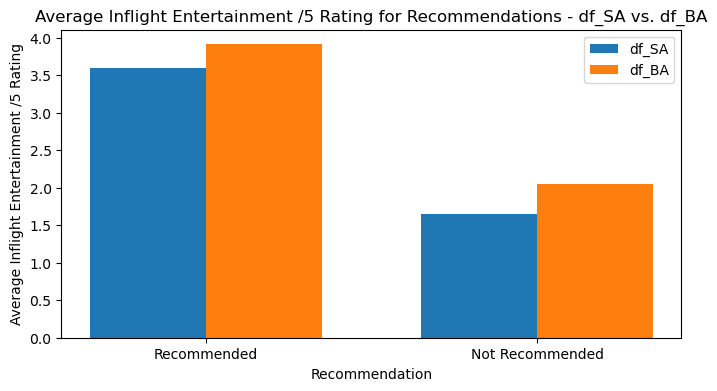

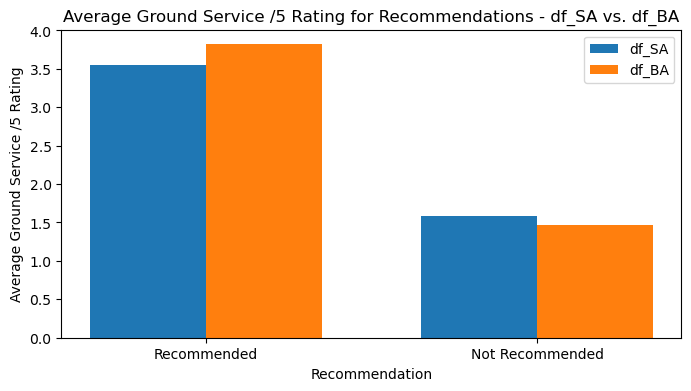

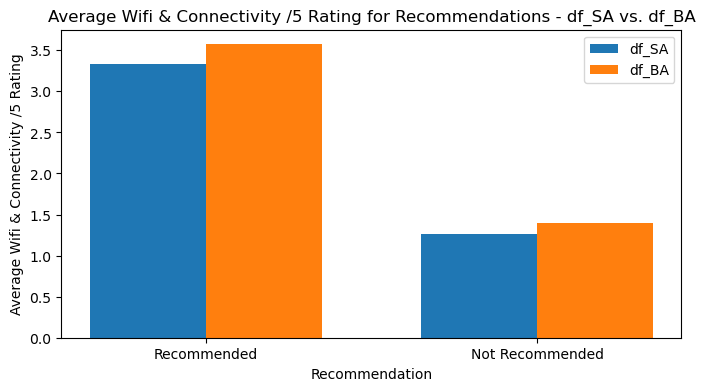

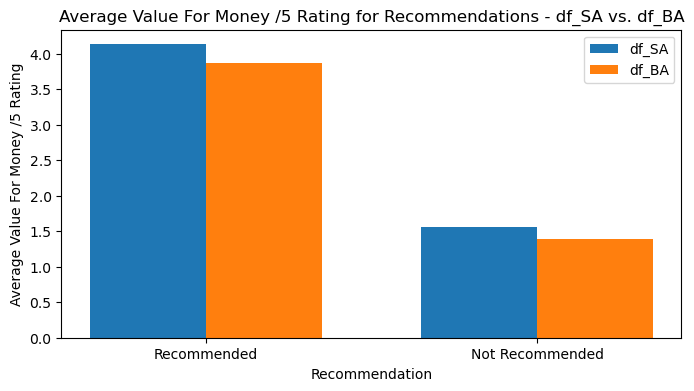

In [101]:
for category in rating_categories:
    # Calculate average rating for recommended vs not recommended in df_SA
    avg_rating_recommended_df_SA = df_SA[df_SA['Recommended'] == 'yes'][category].mean()
    avg_rating_not_recommended_df_SA = df_SA[df_SA['Recommended'] == 'no'][category].mean()

    # Calculate average rating for recommended vs not recommended in df_BA
    avg_rating_recommended_df_BA = df_BA[df_BA['Recommended'] == 'yes'][category].mean()
    avg_rating_not_recommended_df_BA = df_BA[df_BA['Recommended'] == 'no'][category].mean()

    # Bar Chart
    plt.figure(figsize=(8, 4))
    bar_width = 0.35
    index = np.arange(2)
    
    plt.bar(index, [avg_rating_recommended_df_SA, avg_rating_not_recommended_df_SA], bar_width, label='df_SA')
    plt.bar(index + bar_width, [avg_rating_recommended_df_BA, avg_rating_not_recommended_df_BA], bar_width, label='df_BA')

    plt.xlabel('Recommendation')
    plt.ylabel(f'Average {category} Rating')
    plt.title(f'Average {category} Rating for Recommendations - df_SA vs. df_BA')
    plt.xticks(index + bar_width / 2, ['Recommended', 'Not Recommended'])
    plt.legend()

    plt.show()


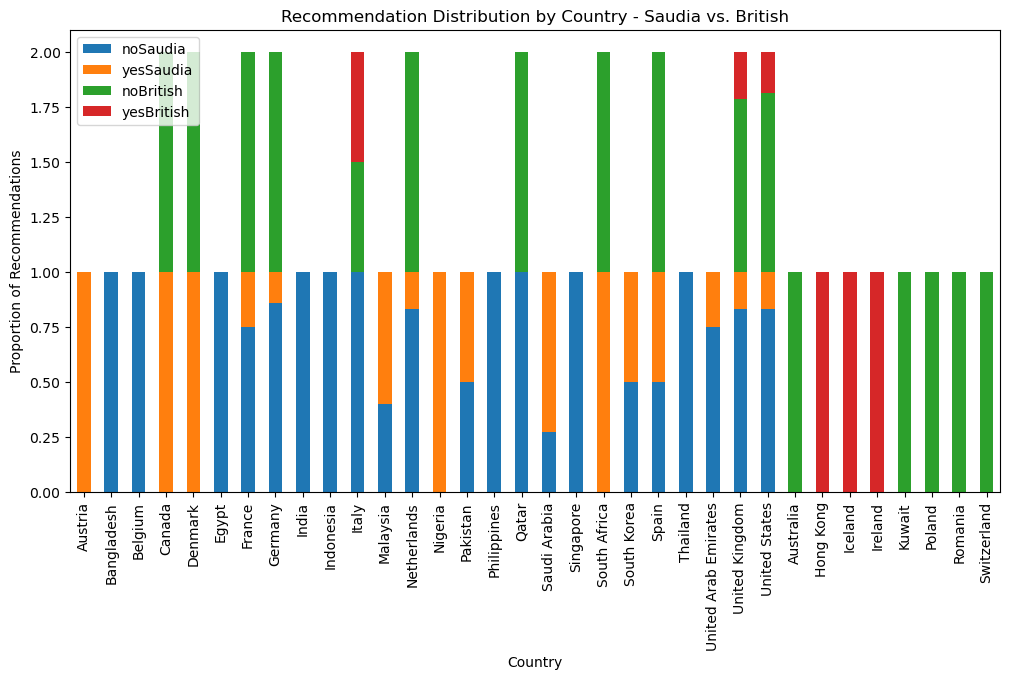

In [103]:
# Calculate the proportion of recommendations per country for df_SA
country_recommendation_df_SA = df_SA.groupby('Country')['Recommended'].value_counts(normalize=True).unstack().fillna(0)

# Calculate the proportion of recommendations per country for df_BA
country_recommendation_df_BA = df_BA.groupby('Country')['Recommended'].value_counts(normalize=True).unstack().fillna(0)

# Combine and prepare data for plotting
combined_recommendations = pd.concat([country_recommendation_df_SA.add_suffix('Saudia'), country_recommendation_df_BA.add_suffix('British')], axis=1).fillna(0)

# Plotting
ax = combined_recommendations.plot(kind='bar', stacked=True, figsize=(12, 6))
ax.set_xlabel('Country')
ax.set_ylabel('Proportion of Recommendations')
ax.set_title('Recommendation Distribution by Country - Saudia vs. British')
ax.tick_params(axis='x', rotation=90)
plt.legend(loc='upper left')
plt.show()

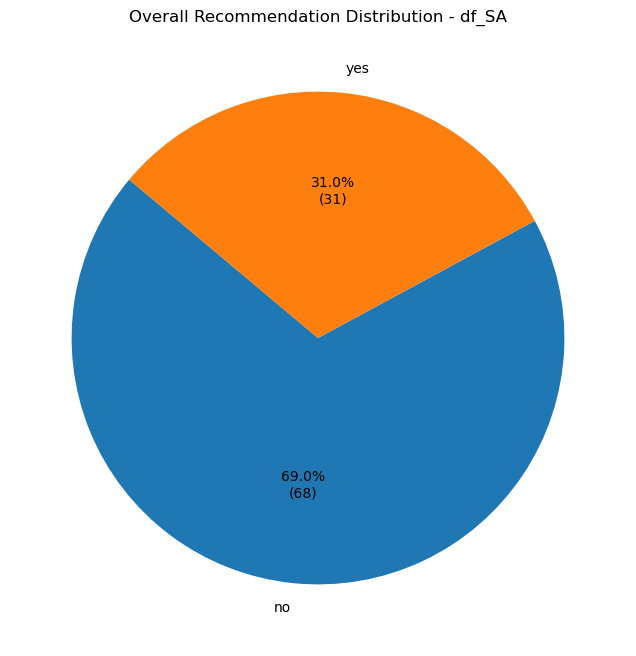

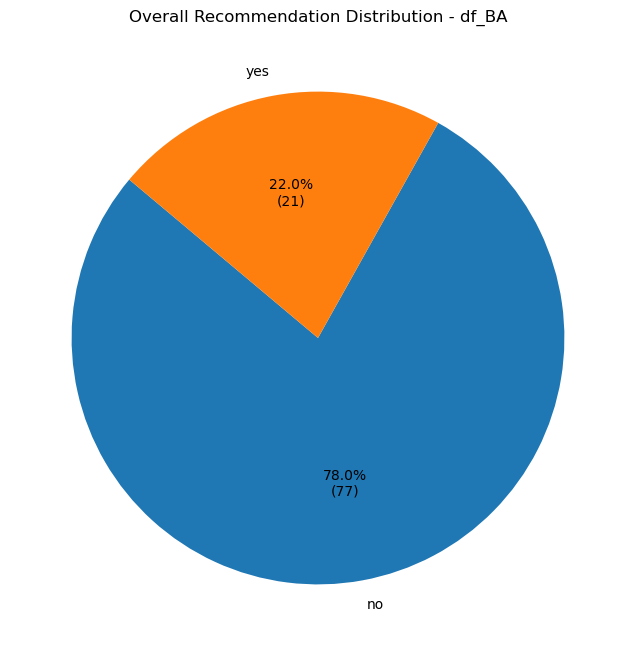

In [105]:
# Count of recommendations for df_SA
recommendation_counts_df_SA = df_SA['Recommended'].value_counts()

# Count of recommendations for df_BA
recommendation_counts_df_BA = df_BA['Recommended'].value_counts()

# Function to format the label with percentage and absolute number
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Pie Chart for df_SA
plt.figure(figsize=(8, 8))
plt.pie(recommendation_counts_df_SA, labels=recommendation_counts_df_SA.index, autopct=lambda pct: func(pct, recommendation_counts_df_SA),
        startangle=140)
plt.title('Overall Recommendation Distribution - df_SA')
plt.show()

# Pie Chart for df_BA
plt.figure(figsize=(8, 8))
plt.pie(recommendation_counts_df_BA, labels=recommendation_counts_df_BA.index, autopct=lambda pct: func(pct, recommendation_counts_df_BA),
        startangle=140)
plt.title('Overall Recommendation Distribution - df_BA')
plt.show()


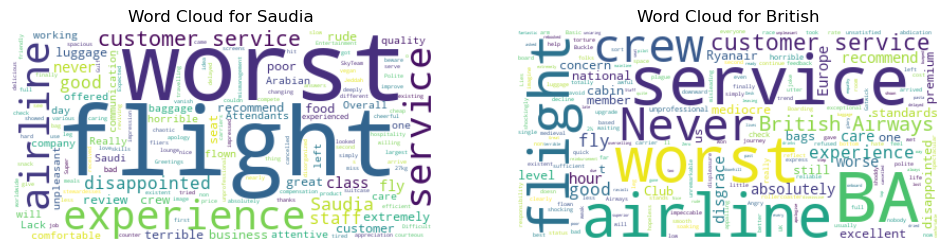

In [107]:
# Concatenate all review comments into a single string for df_SA
text_SA = ' '.join(review for review in df_SA['Comment'] if isinstance(review, str))

# Generate word cloud for df_SA
wordcloud_SA = WordCloud(background_color='white').generate(text_SA)

# Concatenate all review comments into a single string for df_BA
text_BA = ' '.join(review for review in df_BA['Comment'] if isinstance(review, str))

# Generate word cloud for df_BA
wordcloud_BA = WordCloud(background_color='white').generate(text_BA)

# Display word clouds side by side
plt.figure(figsize=(12, 6))

# Word cloud for df_SA
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(wordcloud_SA, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Saudia')

# Word cloud for df_BA
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(wordcloud_BA, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for British')

plt.show()
